This is a Python implementation of MATLAB demo code provided by the course *Monte Carlo Methods in Finance* provided by iversity.org

https://iversity.org/my/courses/monte-carlo-methods-in-finance/


# Week 4

In [4]:
from __future__ import division
from numpy import *
import statsmodels
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import numpy as np

#### demo_FourierTransform -- Lecture 4.2

Here we look at how we can classify noise. This is done using the Fourier transform of a (possibly noisy) signal

In [5]:
N = 2**12  # number of time steps
t0 = 0     # initial time
T = 50     # Length of interval

First we look at a sinusiodal time series without noise, and the corresponding Fourier transform.

In [6]:
t = linspace(t0, t0 + T, N)

w1 = 10  # frequencies
w2 = 12
f = .4 * sin(w1 * t) + .6 * sin(w2 * t)

# Fourier transform of f and its power spectrum (i.e. the 'contribution' of frequencies to the signal f)
FT_f = fft.fft(f) / N
powerSpectrum_f = np.abs(fft.fftshift(FT_f))**2

We define an function for visualization purposes.

In [7]:
def auxPlot(t, signal, N, T, powerspectrum):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(211)
    nPlot = 1000
    ax1.plot(t[:nPlot], signal[:nPlot])
    ax1.set_xlabel('t', fontsize=18)
    ax1.set_ylabel('f(t)', fontsize=18)
    ax1.set_xbound(np.min(t[:nPlot]), np.max(t[:nPlot]))
    ax1.set_ybound(np.min(signal[:nPlot]) * 1.1, np.max(signal[:nPlot]) * 1.1)
    
    wPlot = pi * N / T * linspace(-1, 1, N)   # N is simply the size of the powerspectrum array.
    ax2 = fig.add_subplot(212)
    ax2.plot(wPlot, powerspectrum) 
    ax2.set_xlabel('w', fontsize=18)
    ax2.set_ylabel('FT', fontsize=18)
    ax2.set_ybound(0, np.max(powerspectrum) * 1.1)
    ax2.set_xbound(np.min(wPlot), np.max(wPlot))
    plt.tight_layout()
    
    return ax1, ax2

The powerspectrum shows 4 clear peaks, associated with the two sinusoidal frequencies present in the signal.

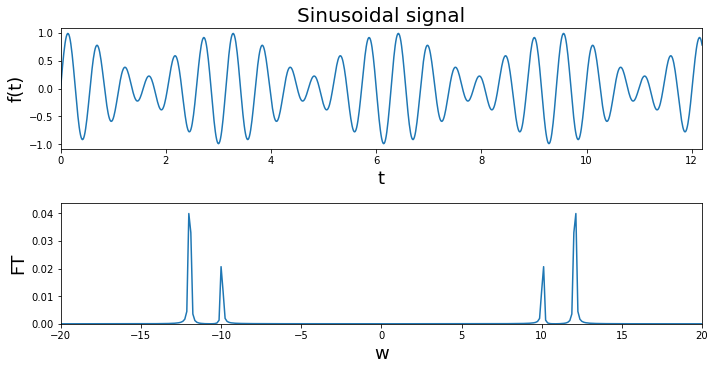

In [8]:
ax1, ax2 = auxPlot(t, f, N, T, powerSpectrum_f)
ax2.set_xbound(-20, 20)
ax1.set_title('Sinusoidal signal', fontsize=20);
plt.show()

Gaussian white noise is characterized by an approximately uniform powerspectrum. On average, the contribution of each frequency present to the signal is the same. The signal itself is generated by drawing independent samples from a normal distribution at each timestep.

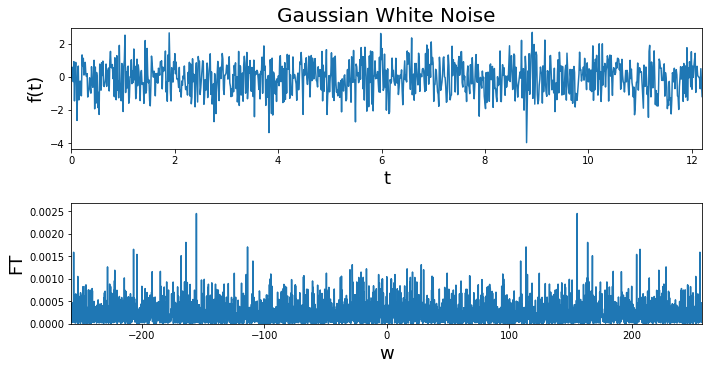

In [9]:
X = random.randn(N)

FT_X = fft.fft(X) / N
powerSpectrum_X = np.abs(fft.fftshift(FT_X))**2

ax1, ax2 = auxPlot(t, X, N, T, powerSpectrum_X)
ax1.set_title('Gaussian White Noise', fontsize=20);
plt.show()

 Finally we combine the two signals, forming a noise sinusoidal signal. The two signals are added (with some amplitude for the noise). Note that although the Fourier transform is linear, the powerspectrum is not (although the power spectrum does not mix frequencies).

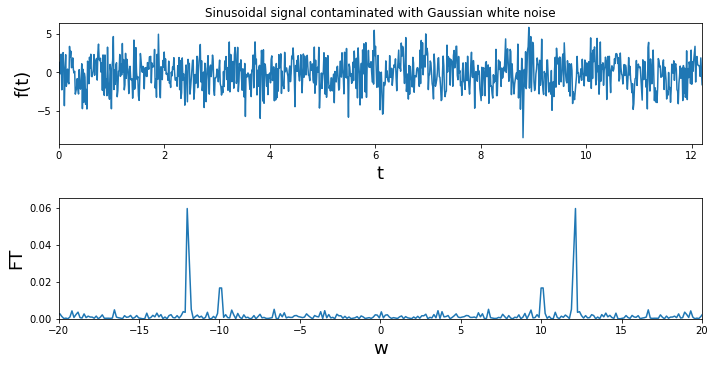

In [10]:
noiseAmp = 2
fx = f + noiseAmp * X
FT_fx = fft.fft(fx)/N
powerSpectrum_fx = np.abs(fft.fftshift(FT_fx))**2

ax1, ax2 = auxPlot(t, fx, N, T, powerSpectrum_fx)
ax1.set_title('Sinusoidal signal contaminated with Gaussian white noise')
ax2.set_xbound(-20,20)
plt.show()

#### demo_autocorrelations: autocorrelations for different time series -- Lecture 4.3

In [11]:
maxLag = 15
N = 1000

We define our own autocorrelation functions using numpy.correlate. This function computes the correlation for all delays, including negative ones. These negative delays do not contain more info for an *auto*correlation.

In [12]:
def autocorrelation(X, maxLag):
    corr = np.correlate(X, X, mode='full')[X.size - 1:]  # numpy.correlate returns a bit more than just the correlation.
    corr  = corr / corr[0]
    return corr[:maxLag+1], np.arange(0, maxLag +1)

We also define another wrapper function for visualization. This include a sample of the signal, and a bar chart of the autocorrelation (with some maxLag). The autocorrelation also plots confidence intervals for the sample correlations -- correlations underneath this confidence interval are u

In [13]:
def plotResults(X, maxLag):
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(211)
    nPlot = 1000
    ax1.plot(np.arange(1, nPlot+1), X[:nPlot])
    ax1.set_ylabel('Signal', fontsize=16)
    ax1.set_xlabel('t', fontsize=16)
    ax2 = fig.add_subplot(212)
    plotAutocorrelation(ax2, X, maxLag)
    plt.tight_layout()
    return ax1, ax2

def plotAutocorrelation(ax2, X, maxLag):
    u1 = 2. / np.sqrt(X.size)  # estimate of 95% confidence interval. (compare to the usual 1.96/sqrt(n) )
    corr, corr_range = autocorrelation(X, maxLag)
    ax2.bar(corr_range, corr, width=.9, color='g', align = 'center')
    ax2.plot([-3, maxLag +2], [u1,u1], color='r', linewidth=1.5, label='Confidence Interval')
    ax2.plot([-3, maxLag +2], [-u1,-u1], color='r', linewidth=1.5)
    ax2.set_xbound(-.45, maxLag+.45)
    ax2.set_ylabel('autoorrelation', fontsize=16)
    ax2.set_xlabel('delay', fontsize=16)
    ax2.legend()

First look at the autocorrelation of Gaussian white noise. This should vanish for all non-zero delays, since the time series is essentially a collection of independently drawn samples.

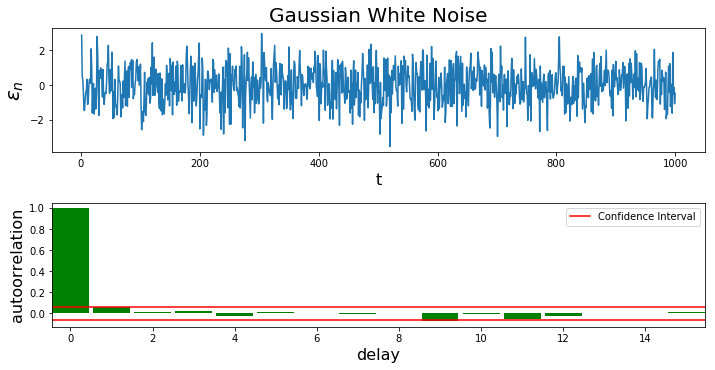

In [14]:
sigma = 1
epsilon = random.randn(N)
ax1, ax2 = plotResults(epsilon, maxLag)
ax1.set_title("Gaussian White Noise", fontsize=20);
ax1.set_ylabel(r'$\epsilon_n$', fontsize=20);
plt.show()

The moving average is more interesting. We define MA(1) as $X_n = \theta_0 + \theta_1 \epsilon_{n-1} + \sigma \epsilon_n$. Here $\epsilon_n \sim N(0,1)$ are i.i.d random variables, drawn from a normal distribution. The signal has fixed parameters $\theta_0$, $\theta_1$ and $\sigma$. It's called a moving average, because the signal at time $t_{n}$ is partially determined by the previously drawn random variable $\epsilon_{n-1}$. Therefore, you expect the signal to contain a non-zero autocorrelation at delay 1, but zero at higher delays.

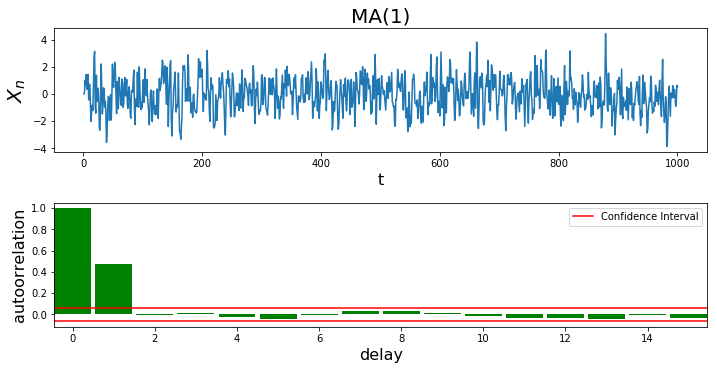

In [15]:
theta0 = 0
theta1 = .8
sigma = 1
epsilon = random.randn(N)

X = theta0 + sigma * epsilon             # initialization of X
X[0] = theta0                            # Reset the initial value of X
X[1:] = X[1:] + theta1 * epsilon[0:-1]   # add the delayed signal

ax1, ax2 = plotResults(X, maxLag)
ax1.set_title("MA(1)", fontsize=20);
ax1.set_ylabel(r'$X_n$', fontsize=20);
plt.show()

Finally, we also look at the autoregressive function AR(1). In this case the signal at time $t_{n}$ depends partially on the signal at time $t_{n-1}$ (In contrast to MA(1), which only depended on the change in the signal at previous times). We write $X_n = \phi_0 + \phi_1 X_{n-1} + \sigma \epsilon_n$ Here you can expect that the autocorrelation is non-zero for all delays.

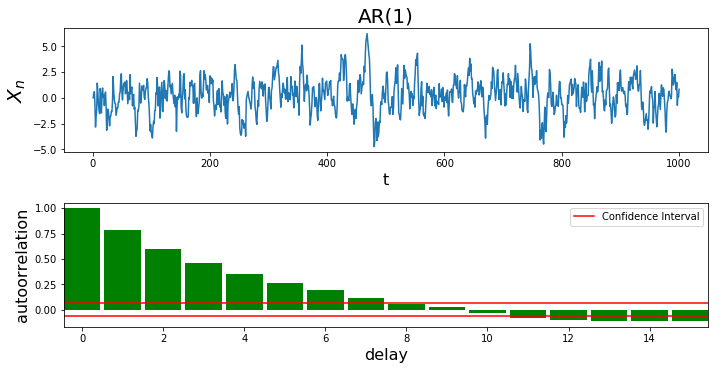

In [16]:
phi0 = 0
phi1 = .8
sigma = 1
epsilon = random.randn(N)

X = phi0 + sigma * epsilon             # initialization of X
X[0] = phi0/(1-phi1)                   # Reset the initial value of X
for i in range(1, X.size):
    X[i] = X[i] + phi1 * X[i-1]  # add the delayed signal

ax1, ax2 = plotResults(X, maxLag)
ax1.set_title("AR(1)", fontsize=20);
ax1.set_ylabel(r'$X_n$', fontsize=20);
plt.show()

#### demo_WienerProcess -- Lecture 4.5

A Wiener process is characterized by the property: $W(t + \Delta T) - W(t) \sim \sqrt{\Delta T} N(0,1)$. In addition the function is continuous and $W(0) = 0$. The way to read the main property is that the processes $W(t_1) - W(s_1)$ and $W(t_2) - W(s_2)$ are independent random variables for different times $t_i$ and $s_i$. In addition, the variance of these processes grows with the square root of the time difference.

We first define a function which generates a (discrete) Wiener Process

In [17]:
def simulateWienerProcess(M, N, T):
    deltaT = T/ N
    t = linspace(0, T, N+1)
    X = c_[zeros((M,1)), random.randn(M, N)]   # initial value is zero; c_ combines glues arrays together column-wise
    return t, cumsum(sqrt(deltaT) * X, axis=1)

In [18]:
from custom_functions_iversity import graphicalComparisonPdf   # custom file availabel at github
from scipy.stats import norm


def demo_WienerProcess(M, N):
    T = 2
    t, W = simulateWienerProcess(M, N, T)

    if (M < 30):  # just plot all processes
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)    
        ax.plot(t, W.T)
        

    else:   # 
        WT = W[:,-1]  # final values
        def modelPDF(x):
            return norm.pdf(x, 0, sqrt(T))
        graphicalComparisonPdf(WT, modelPDF, 0, np.min(W), np.max(W))
        
        expected_W = zeros_like(t)
        std_W =2 * sqrt(t)
        
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)    
        ax.plot(t, W.T)
        
        # expected value is simply zero
        ax.plot(t, expected_W, 'black', linewidth=4)    
        
        # this regions represents the interval [mu - 2 * sigma, mu + 2 * sigma], with sigma time dependent.
        ax.plot(transpose([t,t]), transpose([std_W, -std_W]), 'black', linewidth=4)  
    ax.set_xlabel('t',fontsize=20)
    ax.set_ylabel('W(t)',fontsize=20)
    plt.tight_layout()
demo_WienerProcess(1000,100)

#### demo_WienerProcess_statisticalProperties: Statistical properties of the Wiener process -- Lecture 4.6

We simulate M Wiener processes over a range T, with timestep T/N.

In [19]:
T = 10
N = 500
M = 1000

t, W = simulateWienerProcess(M, N, T)

We compare the sample statistics to the true value as a function of time.

In [20]:
mean_W = 0
estimated_mean_W = np.mean(W, axis=0)

std_W = sqrt(t)
estimated_std_W = np.std(W, axis=0)

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(211)
ax1.plot(t, estimated_mean_W, label='sample')
ax1.plot([t[0], t[-1]], [mean_W, mean_W], label='exact')
ax1.set_xlabel('t', fontsize=20)
ax1.set_ylabel('E[W(t)]', fontsize=20)
ax1.set_ybound(-.15, .15)
ax1.set_xbound(t[0], t[-1])
ax2.legend(loc='lower right')

ax2 = fig.add_subplot(212)
ax2.plot(t, std_W, label= 'exact')
ax2.plot(t, estimated_std_W,label='sample')
ax2.legend(loc='lower right')
ax2.set_xlabel('t', fontsize=20)
ax2.set_ylabel('std[W(t)]', fontsize=20)
ax2.set_ybound(0,t[-1]**(.5) + 1) 
ax2.set_xbound(t[0], t[-1]) 
ax2.legend(loc='lower right')
plt.tight_layout()

#### demo_WienerProcess_maxima -- Lecture 4.7

In [21]:
T = 10
N = 500
M = 1000

t, W = simulateWienerProcess(M, N, T)

In [22]:
mean_WT = 0
std_WT = sqrt(T)
alpha = 4
nPoints = 600
level = linspace(0, mean_WT + alpha * std_WT, nPoints)

exact_P = 2 * (1 - norm.cdf(level, 0, std_WT))   # true probability distribution
estimated_P = mean(any(W[..., newaxis] > level[newaxis, newaxis, :], axis=1), axis=0)  # sample distribution

To clarify this last statement: We first look at all processes which cross a certain level. We do this in a vectorized way by computing

`any(W[..., newaxis] > level[newaxis, newaxis, :], axis=1)`

The `any` function returns true if a Wiener process crosses a certain level at any given time. This function therefore counts the number of Wiener processes which cross a certain level at any given time. It performs this for all possible levels.

Next, we take the mean over the Wiener processes. This gives back the fraction of Wiener processes which cross a given level. This distribution is plotted below and compared to the exact distribution.

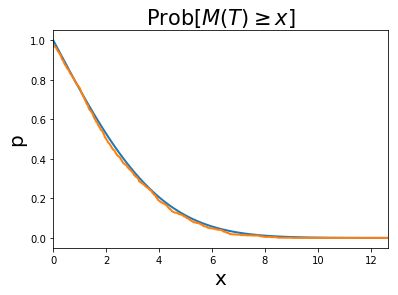

In [24]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.plot(level, exact_P, label='exact', linewidth=2)
ax.plot(level, estimated_P, label='sample', linewidth=2)
ax.set_title(r'Prob[$M(T)\geq x$]', fontsize=21)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('p', fontsize=20)
ax.set_xbound(min(level), max(level))
plt.show()

#### demo_arithmeticBrownianMotion -- Lecture 4.8

Next we look at Arithmetic Brownian motion. We first define a function that generates a set simulations.

In [25]:
def simulateArithmeticBrownianMotion(M,N,t0,B0,T,mu,sigma):
    deltaT = T / N
    t = linspace(t0, t0 + T, N + 1)
    X = random.randn(M, N)
    d = c_[ B0 * ones((M, 1)), mu * deltaT + sigma * sqrt(deltaT) * X ]
    B = cumsum(d, axis=1)
    return t, B

In [26]:
M = 100
N = 500
t0 = 0
T = 2
B0 = 0
mu = 1
sigma = .5

t, B = simulateArithmeticBrownianMotion(M, N, t0, B0, T, mu, sigma)

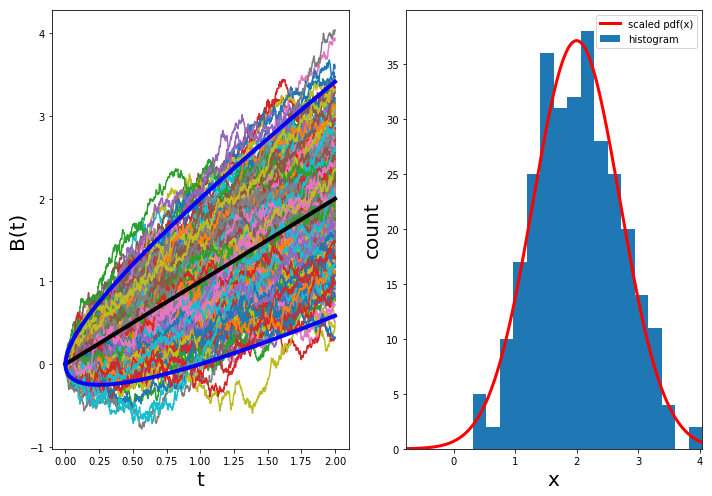

In [29]:
def demo_ArithmeticBrownianMotion(M, N, t0, B0, T, mu, sigma):
    T = 2
    t, B = simulateArithmeticBrownianMotion(M, N, t0, B0, T, mu, sigma)

    if (M < 30):  # just plot all processes
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(111)    
        ax.plot(t, B.T)
        

    else:   # 
        BT = B[:,-1]  # final values
        def modelPDF(x):
            return norm.pdf(x, mu * T, sigma* sqrt(T))
        
        fig = plt.figure(figsize=(10,7))
        ax2 = fig.add_subplot(122)    

        graphicalComparisonPdf(BT, modelPDF, 0, np.min(B), np.max(B), axes_object=ax2)
        ax2.set_ylabel('count', fontsize=20)
        ax2.set_xlabel('x', fontsize=20)
        expected_B = B0 + mu * t
        std_B = sigma * sqrt(t)
        ax1 = fig.add_subplot(121)
        ax1.plot(t, B.T)
        # expected value is simply zero
        ax1.plot(t, expected_B, 'black', linewidth=4)    
        alpha = 2
        # this regions represents the interval [mu - 2 * sigma, mu + 2 * sigma], with sigma time dependent.
        ax1.plot(transpose([t,t]), transpose([expected_B + alpha* std_B, expected_B-alpha*std_B]), 'b', linewidth=4)  
    ax1.set_xlabel('t',fontsize=20)
    ax1.set_ylabel('B(t)',fontsize=20)
    plt.tight_layout()
    
    
demo_ArithmeticBrownianMotion(300, 1000, t0, B0, T, mu, sigma)
plt.show()

The right graph represents the distribution of end points of the left graph (I could not get the rotation to work).

#### demo_arithmeticBrownianMotion_statisticalProperties -- Lecture 4.9

Setting some parameters and creating a sample of Brownian motions.

In [30]:
mu = 1
sigma = .5

t0 = 0
B0 = 0
M = 50
T = 2 
N = 500

t, B = simulateArithmeticBrownianMotion(M, N, t0, B0, T, mu, sigma)

Here we compare the time-dependent sample mean and standard deviation to the expected quantities.

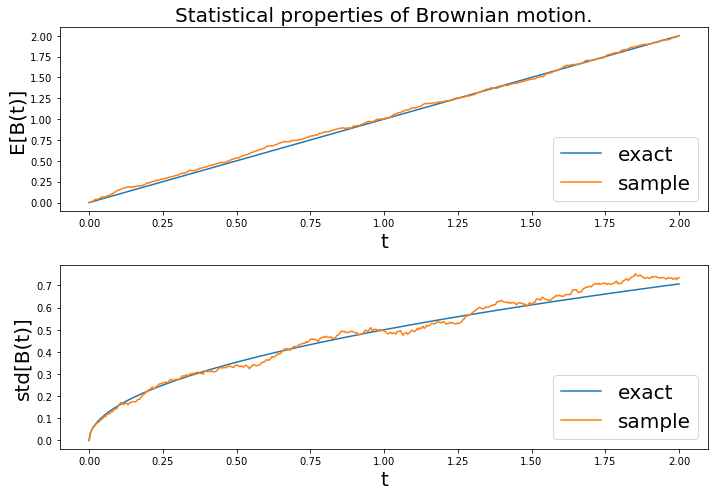

In [31]:
mean_B = B0 + mu *(t-t0)
std_B = sigma * sqrt(t - t0)

# sample mean and std
estimated_mean_B = mean(B, axis=0)
estimated_std_B = std(B, axis=0)

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax1.plot(t, mean_B, label='exact')
ax1.plot(t, estimated_mean_B, label='sample')
ax1.set_title('Statistical properties of Brownian motion.', fontsize=20)
ax1.set_xlabel('t',fontsize=20)
ax1.set_ylabel('E[B(t)]', fontsize=20)
ax1.legend(loc='lower right', fontsize=20)

ax2 = fig.add_subplot(212)
ax2.plot(t, std_B, label='exact')
ax2.plot(t, estimated_std_B, label='sample')
ax2.set_xlabel('t',fontsize=20)
ax2.set_ylabel('std[B(t)]', fontsize=20)
ax2.legend(loc='lower right',fontsize=20)

plt.tight_layout()
plt.show()

#### demo_BrownianBridge -- Lecture 4.10

In [32]:
def simulateBrownianBridge(M,t1,B1,t2,B2,t,sigma):
    mu_B = B1 + (B2 - B1) * (t-t1)/(t2-t1)
    sigma_B = sigma * sqrt((t-t1)*(t2-t)/(t2-t1))
    if t == t1:
        B = B1 * ones(M)
    elif t == t2:
        B = B2 * ones(M)
    else:
        B = mu_B + sigma_B * random.randn(M)
    
    
    return B, mu_B, sigma_B

In [33]:
t1 = 0
B1 = 0

t2 = 10
B2 = 12

tau = 4

sigma = 2

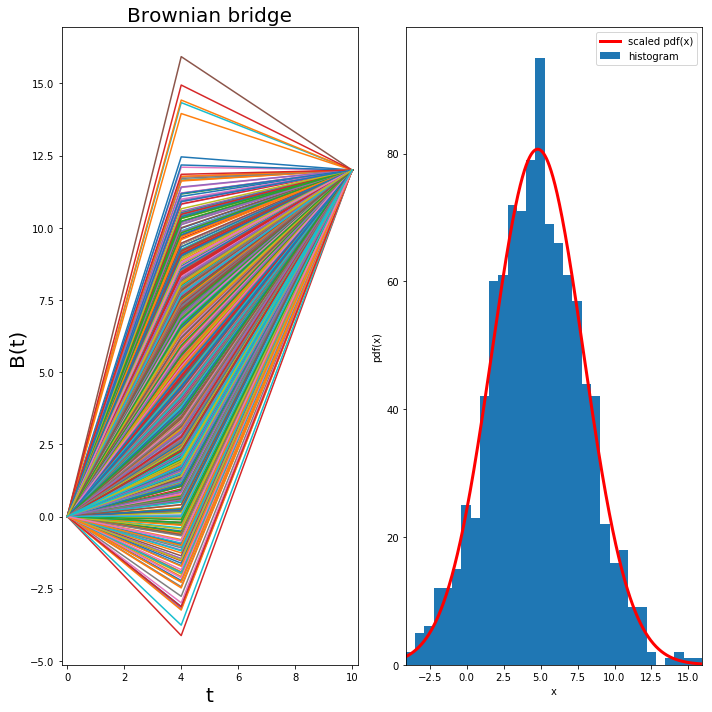

In [34]:
M = 1000
B, mu_B, sigma_B = simulateBrownianBridge(M,t1,B1,t2,B2,tau,sigma)


t = asarray([t1, tau, t2])
Bt = asarray([B1 *ones(M), B, B2 * ones(M)])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121)
ax.scatter([t[0] * ones(M), t[1] * ones(M), t[2] * ones(M)], 
            Bt, c='white', marker='o', s=100)
ax.plot(t,Bt);

ax.set_title('Brownian bridge', fontsize=20)
ax.set_ylabel('B(t)', fontsize=20)
ax.set_xlabel('t', fontsize=20)
ax.set_xbound(t1-.2, t2+.2)

ax2 = fig.add_subplot(122)

def modelPDF(x):
    return norm.pdf(x, mu_B, sigma_B)

graphicalComparisonPdf(B, modelPDF, 0, np.min(B), np.max(B), axes_object=ax2)   # distribution of middle points
plt.tight_layout()
plt.show()